In [189]:
import torch.nn as nn
import time
import torch.optim as optim
from autoencoder_model_segnet_rev1 import SegNet
import torch
from torchvision import models
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from address_gram_dataset import AddressGramDataset
from torch.utils.data import DataLoader
from utils import *
import matplotlib.pyplot as plt
import cv2 as cv
from encoder_rev1 import Encoder
from sklearn import svm
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# Define train and val loops

In [2]:
def train(epoch, train_loader, model, optimizer):
    # Ensure dropout layers are in train mode
    model.train()

    batch_time = ExpoAverageMeter()  # forward prop. + back prop. time
    losses = ExpoAverageMeter()  # loss (per word decoded)

    start = time.time()

    # Batches
    for i_batch, (x, y) in enumerate(train_loader):
        # Set device options
        x = x.to(device)
        y = y.to(device)

        # print('x.size(): ' + str(x.size())) # [32, 3, 224, 224]
        # print('y.size(): ' + str(y.size())) # [32, 3, 224, 224]

        # Zero gradients
        optimizer.zero_grad()

        y_hat = model(x)
        # print('y_hat.size(): ' + str(y_hat.size())) # [32, 3, 224, 224]

        loss = torch.sqrt((y_hat - y).pow(2).mean())
        loss.backward()

        optimizer.step()

        # Keep track of metrics
        losses.update(loss.item())
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i_batch % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i_batch, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  loss=losses))
            
    return losses.avg

In [3]:
def valid(val_loader, model):
    model.eval()  # eval mode (no dropout or batchnorm)

    batch_time = ExpoAverageMeter()  # forward prop. + back prop. time
    losses = ExpoAverageMeter()  # loss (per word decoded)

    start = time.time()

    with torch.no_grad():
        # Batches
        for i_batch, (x, y) in enumerate(val_loader):
            # Set device options
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)

            loss = torch.sqrt((y_hat - y).pow(2).mean())

            # Keep track of metrics
            losses.update(loss.item())
            batch_time.update(time.time() - start)

            start = time.time()

            # Print status
            if i_batch % print_freq == 0:
                print('Validation: [{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(i_batch, len(val_loader),
                                                                      batch_time=batch_time,
                                                                      loss=losses))

    return losses.avg

In [4]:
def plot_graph(train_losses, val_losses):
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend(loc='best')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    
    plt.savefig('autoencoder_training_fig.png')

# Load training/val dataset for one font only

In [60]:
# create dataset, pass in path to dir of images
arial_bold_train_dataset = AddressGramDataset('./address_grams/arialbold/train')
arial_bold_val_dataset = AddressGramDataset('./address_grams/arialbold/val')

In [61]:
BATCH_SIZE = 16

# create dataloader
arial_bold_train_dataloader = DataLoader(arial_bold_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
arial_bold_val_dataloader = DataLoader(arial_bold_val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
def main():
    
    start_time = time.time()
    
    train_loader = arial_bold_train_dataloader
    val_loader = arial_bold_val_dataloader

    # Create SegNet model
    label_nbr = 3
    model = SegNet(label_nbr)

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [40, xxx] -> [10, ...], [10, ...], [10, ...], [10, ...] on 4 GPUs
        model = nn.DataParallel(model)
    # Use appropriate device
    model = model.to(device)
    # print(model)

    # define the optimizer
    # optimizer = optim.LBFGS(model.parameters(), lr=0.8)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_loss = 100000
    epochs_since_improvement = 0
    
    train_losses = []
    val_losses = []
    
    num_epoch_since_last_save = 0

    # Epochs
    for epoch in range(start_epoch, epochs):
        # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
        if epochs_since_improvement == 20:
            break
        if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
            adjust_learning_rate(optimizer, 0.8)

        # One epoch's training
        train_loss = train(epoch, train_loader, model, optimizer)

        # One epoch's validation
        val_loss = valid(val_loader, model)
        print('\n * LOSS - {loss:.3f}\n'.format(loss=val_loss))
        
        # append losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Check if there was an improvement
        is_best = val_loss < best_loss
        best_loss = min(best_loss, val_loss)

        if not is_best:
            epochs_since_improvement += 1
            print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))
        else:
            epochs_since_improvement = 0

        # only save checkpoint every 5 epochs or if last one
        if epoch % 5 == 0 and epoch > 80:
            num_epoch_since_last_save = 0
            print('Saving checkpoint at epoch:', epoch)
            save_checkpoint(epoch, model, optimizer, val_loss, is_best)
            
            
    plot_graph(train_losses, val_losses)
    
    # print total training time
    print('total training time (mins): ', (time.time() - start_time) / 60)

Let's use 4 GPUs!
Epoch: [0][0/250]	Batch Time 5.991 (0.599)	Loss 0.8941 (0.0894)	
Epoch: [0][20/250]	Batch Time 0.172 (0.217)	Loss 0.8172 (0.7420)	
Epoch: [0][40/250]	Batch Time 0.172 (0.173)	Loss 0.8067 (0.8010)	
Epoch: [0][60/250]	Batch Time 0.158 (0.158)	Loss 0.8014 (0.8025)	
Epoch: [0][80/250]	Batch Time 0.161 (0.163)	Loss 0.7974 (0.7995)	
Epoch: [0][100/250]	Batch Time 0.156 (0.159)	Loss 0.7958 (0.7966)	
Epoch: [0][120/250]	Batch Time 0.170 (0.162)	Loss 0.7932 (0.7938)	
Epoch: [0][140/250]	Batch Time 0.166 (0.159)	Loss 0.7901 (0.7912)	
Epoch: [0][160/250]	Batch Time 0.161 (0.159)	Loss 0.7878 (0.7890)	
Epoch: [0][180/250]	Batch Time 0.156 (0.157)	Loss 0.7869 (0.7871)	
Epoch: [0][200/250]	Batch Time 0.155 (0.158)	Loss 0.7831 (0.7849)	
Epoch: [0][220/250]	Batch Time 0.160 (0.158)	Loss 0.7817 (0.7826)	
Epoch: [0][240/250]	Batch Time 0.155 (0.160)	Loss 0.7792 (0.7804)	
Validation: [0/63]	Batch Time 0.082 (0.008)	Loss 0.7760 (0.0776)	
Validation: [20/63]	Batch Time 0.076 (0.069)	Loss 0

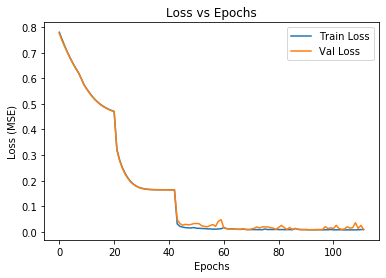

In [8]:
if __name__ == '__main__':
    main()

# Testing time

In [2]:
# Create SegNet model to load saved state
# label_nbr = 3
# saved_model = SegNet(label_nbr)
model_path = './models/checkpoint_95_0.009.tar'

# load the model state dict
saved_state_dict = torch.load(model_path)

In [23]:
label_nbr = 3
loaded_model = SegNet(label_nbr)
# new_model = nn.DataParallel(new_model)

In [24]:
loaded_model.load_state_dict(saved_state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [25]:
# # put in eval mode
# loaded_model = saved_state_dict['model']

In [6]:
loaded_model.to(device)  # place on gpu/ cpu
loaded_model.eval()  # set eval mode

SegNet(
  (down1): segnetDown2(
    (conv1): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (conv2): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (maxpool_with_argmax): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): segnetDown2(
    (conv1): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (c

In [7]:
# don't forget to use this to run on all gpus
loaded_model = nn.DataParallel(loaded_model)

# Create test datasets & dataloaders

In [3]:
arial_bold_test_dataset = AddressGramDataset('./address_grams/arialbold/test')

# arial_italic_train_dataset = AddressGramDataset('./address_grams/arialitalic/train')
arial_italic_test_dataset = AddressGramDataset('./address_grams/arialitalic/test')

# vera_train_dataset = AddressGramDataset('./address_grams/vera/train')
vera_test_dataset = AddressGramDataset('./address_grams/vera/test')

# arial_train_dataset = AddressGramDataset('./address_grams/arial/train')
arial_test_dataset = AddressGramDataset('./address_grams/arial/test')

In [4]:
BATCH_SIZE = 32

arial_bold_test_dataloader = DataLoader(arial_bold_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# arial_italic_train_dataloader = DataLoader(arial_italic_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
arial_italic_test_dataloader = DataLoader(arial_italic_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# vera_train_dataloader = DataLoader(vera_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
vera_test_dataloader = DataLoader(vera_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# arial_train_dataloader = DataLoader(vera_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
arial_test_dataloader = DataLoader(vera_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Loop through and check reconstruction

In [5]:
def reconstruct(model, dataloader):
    
    for i, (x, y) in enumerate(dataloader):
        
        # only do two batches
        if i == 1:
            break

        x = x.to(device)
        y = y.to(device)

        losses = ExpoAverageMeter()  # loss (per word decoded)

        y_hat = model(x)

        loss = torch.sqrt((y_hat - y).pow(2).mean())

        # Keep track of metrics
        losses.update(loss.item())

    return losses.avg, x, y_hat
        

In [11]:
def _tensor_to_img(tensor):
    out = tensor.cpu().detach().numpy()
    out = np.transpose(out, (1, 2, 0))
    out = out * 255
    out = np.clip(out, 0 , 255)
    out = out.astype(np.uint8)
    out = cv.cvtColor(out, cv.COLOR_RGB2BGR)
    
    return out

# Save reconstructed and original images

In [17]:
def save_images(x, y_hat, font_name):

    for i in range(len(y_hat)):

        y_hat_img = _tensor_to_img(y_hat[i])
        x_img = _tensor_to_img(x[i])
        
        font_path = os.path.join('./', font_name)
        
        if not os.path.exists(font_path):
            os.makedirs(font_path)

        cv.imwrite('./{}/{}_orig.png'.format(font_name, i), x_img)
        cv.imwrite('./{}/{}_rc.png'.format(font_name, i), y_hat_img)


In [18]:
# put all dataloaders in list
dataloaders = {'vera':vera_test_dataloader, 'arial_italic':arial_italic_test_dataloader, 'arial_bold':arial_bold_test_dataloader, 'arial':arial_test_dataloader}

In [19]:
# run on each font
for font_name, dataloader in dataloaders.items():
    
    loss, x, y_hat = reconstruct(loaded_model, dataloader)
    
    print('{} loss: {})'.format(font_name, loss))
    
    save_images(x, y_hat, font_name)

vera loss: 0.0036679647862911217)
arial_italic loss: 0.0037287846207618705)
arial_bold loss: 0.0008422489278018473)
arial loss: 0.0036221120506525033)


# Grab encoder only

In [6]:
encoder = Encoder()

In [7]:
encoder.load_state_dict(saved_state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
encoder.to(device)  # place on gpu/ cpu
encoder.eval()  # set eval mode

Encoder(
  (down1): segnetDown2(
    (conv1): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (conv2): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (maxpool_with_argmax): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): segnetDown2(
    (conv1): conv2DBatchNormRelu(
      (cbr_unit): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
      )
    )
    (

In [9]:
# don't forget to use this to run on all gpus
encoder = nn.DataParallel(encoder)

# Flatten encoding

In [10]:
def flatten(x):
    return x.view(x.shape[0], -1)

# Generate feature encodings for test sets

In [86]:
def get_encodings(encoder, dataloader):
    
    x_enc_list = []
    
    for i, (x, y) in enumerate(dataloader):
        
        # only do 30 bathes
        if i == 20 and dataloader != arial_bold_train_dataloader:
            print('test dataloader stopped', i)
            break
        elif i == 30:
            print('train dataloader stopped', i)
            break
        
        x.requires_grad = False
        x = x.to(device)
        x_encodings = encoder(x)
        
        flat_x_enc = flatten(x_encodings)
        
        # loop thru batch and append each to list
        for j in range(flat_x_enc.shape[0]):
            x_enc_curr = flat_x_enc[j]
            x_enc_curr = x_enc_curr.detach().cpu().numpy()  # put back on cpu
            x_enc_list.append(x_enc_curr)
            del x_enc_curr
        
    return x_enc_list

# Recreate training dataset and dataloader

In [72]:
# create dataset, pass in path to dir of images
arial_bold_train_dataset = AddressGramDataset('./address_grams/arialbold/train')

In [73]:
BATCH_SIZE = 32

# create dataloader
arial_bold_train_dataloader = DataLoader(arial_bold_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Generate train encodings (from same autoencoder trained data)

In [87]:
arial_bold_train_encodings = get_encodings(encoder, arial_bold_train_dataloader)

train dataloader stopped 30


In [88]:
len(arial_bold_train_encodings)

960

# Generate test encodings for each font

In [89]:
arial_bold_test_encodings = get_encodings(encoder, arial_bold_test_dataloader)

test dataloader stopped 20


In [91]:
arial_test_encodings = get_encodings(encoder, arial_test_dataloader)

test dataloader stopped 20


In [92]:
vera_test_encodings = get_encodings(encoder, vera_test_dataloader)

test dataloader stopped 20


In [93]:
arial_italic_test_encodings = get_encodings(encoder, arial_italic_test_dataloader)

test dataloader stopped 20


# Train OC-SVM

In [154]:
oc_svm = svm.OneClassSVM(nu=0.015, kernel='sigmoid', gamma='auto')   # seems to be the best

oc_svm.fit(arial_bold_train_encodings)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='sigmoid',
            max_iter=-1, nu=0.015, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

# Predict OC-SVM on test data

In [155]:
def oc_predict(oc_svm_clf, x, font_name, is_in_class):
    
    if is_in_class:
        bool_val = 1
        descriptor = 'In dist.'
    else:
        bool_val = -1
        descriptor = 'Out dist.'
    
    # predict on test data (different font)
    oc_svm_preds = oc_svm_clf.predict(x)
    
    scores = oc_svm_clf.decision_function(x)

    correct = 0

    # evaluate accuracy
    for pred in oc_svm_preds:
        if pred == bool_val:
            correct += 1

    print('{} accuracy ({}): {:.4}%'.format(font_name, descriptor, 100*(correct/len(oc_svm_preds))))
    
    return scores

In [156]:
# predict on pca features
print('--- Trained on arial bold \n')

scores_arial_bold = oc_predict(oc_svm, arial_bold_test_encodings, 'arial_bold', True)
scores_arial_italic = oc_predict(oc_svm, arial_italic_test_encodings, 'arial_italic', False)
scores_vera = oc_predict(oc_svm, vera_test_encodings, 'vera', False)
scores_arial = oc_predict(oc_svm, arial_test_encodings, 'arial', False)

--- Trained on arial bold 

arial_bold accuracy (In dist.): 97.66%
arial_italic accuracy (Out dist.): 99.06%
vera accuracy (Out dist.): 100.0%
arial accuracy (Out dist.): 100.0%


# Make labels for tSNE

In [181]:
# test labels
arial_bold_test_labels = ['arial_bold'] * len(arial_bold_test_encodings)
arial_italic_test_labels = ['arial_italic'] * len(arial_italic_test_encodings)
vera_test_labels = ['vera'] * len(vera_test_encodings)
arial_test_labels = ['arial'] * len(arial_test_encodings)

# Stack X features and Y labels into one vector each

In [159]:
# must stack in same order in X and Y
X_test_features = np.vstack((arial_bold_test_encodings, arial_test_encodings, vera_test_encodings, arial_italic_test_encodings))

In [182]:
Y_test_labels = np.hstack((arial_bold_test_labels, arial_test_labels, vera_test_labels, arial_italic_test_labels))

# Run tSNE

In [164]:
# Run tSNE on X feature vectors

RS = 42

time_start = time.time()

four_font_tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, random_state=RS).fit_transform(X_test_features)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2560 samples in 2.142s...
[t-SNE] Computed neighbors for 2560 samples in 164.943s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2560
[t-SNE] Computed conditional probabilities for sample 2000 / 2560
[t-SNE] Computed conditional probabilities for sample 2560 / 2560
[t-SNE] Mean sigma: 4.306969
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.682137
[t-SNE] KL divergence after 300 iterations: 1.656413
t-SNE done! Time elapsed: 171.75135111808777 seconds


In [175]:
four_font_tsne.shape

(2560, 2)

In [185]:
Y_test_labels.shape

(2560,)

# Plot fonts embeddings

In [190]:
def plot(x, y):
    
    # this will just take first two components (no matter how many you pass)
    
    # create a dataframe with 3 fields
    df = pd.DataFrame(list(zip(x[:,0], x[:,1])), columns=['Comp-1', 'Comp-2'])
    df['y'] = y
    
    num_unique = len(np.unique(y))

    plt.figure(figsize=(16,10))
    
    plt.ylim(-25, 25)
    plt.xlim(-25, 25)
    sns.scatterplot(
        x="Comp-1", y="Comp-2",
        hue="y",
        palette=sns.color_palette("hls", num_unique),
        data=df,
        legend="full",
        alpha=0.3
    )
    

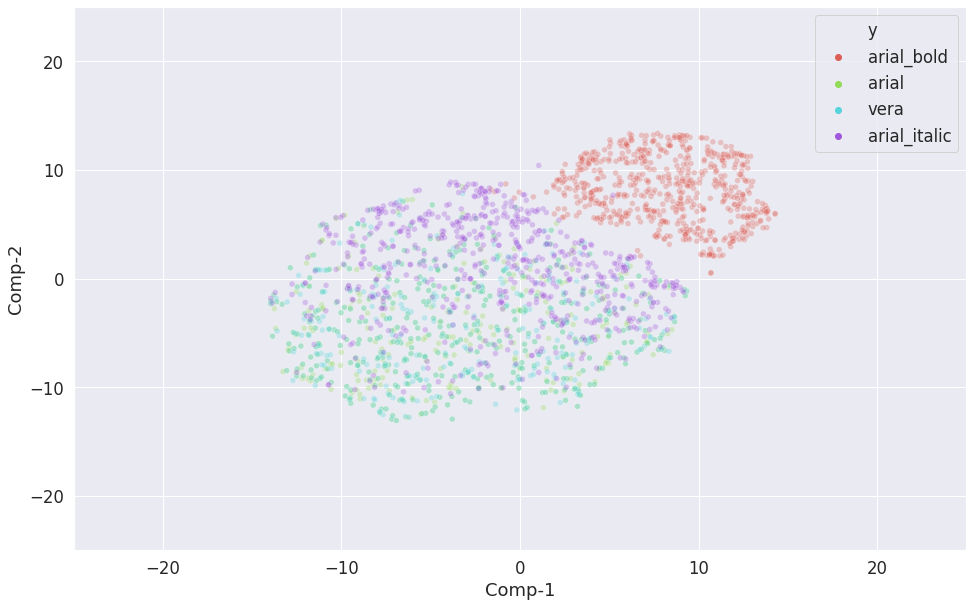

In [191]:
plot(four_font_tsne, Y_test_labels)